In [67]:
# this notebook is inspired by and took code from 
# https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=7HRWe57wyvPF
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
import json

In [2]:
mnist_transform = transforms.Compose([transforms.ToTensor()])
mnist_ds = datasets.MNIST("../mnist", train=True, transform=mnist_transform, download=True)

/usr/local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

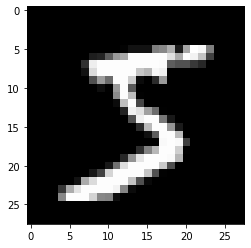

In [3]:
def display_image(image_data):
	plt.imshow(image_data, cmap="gray")

first_image = mnist_ds.data[0]
display_image(first_image)
print(first_image)

In [4]:
batch_size = 64
loader = DataLoader(mnist_ds, batch_size=batch_size, shuffle=True, num_workers=2)
print(loader.dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [5]:
class Encoder(nn.Module):
    def __init__(self, latent=20):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.mean = nn.Linear(in_features=128*7*7, out_features=latent)
        self.variance = nn.Linear(in_features=128*7*7, out_features=latent)

    def forward(self, X):
        # cnn portion
        X = self.conv1(X)
        X = F.relu(X)
        X = self.conv2(X)
        X = F.relu(X)

        # flatten out per batch
        X = X.view(X.size(0), -1)
        
        # fc portion
        pred_mean = self.mean(X)
        pred_variance = self.variance(X)
        
        return pred_mean, pred_variance
        

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent=20):
        super(Decoder, self).__init__()
        self.mirror = nn.Linear(in_features=latent, out_features=128*7*7)
        self.conv2_mirror = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv1_mirror = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1)
    
    def forward(self, X):
        # fc portion
        X = self.mirror(X)

        # unflatten out per batch
        X = X.view(X.size(0), 128, 7, 7)

        # cnn portion
        X = self.conv2_mirror(X)
        X = F.relu(X)
        X = self.conv1_mirror(X)
        X = F.sigmoid(X)

        return X

In [23]:
class Autoencoder(nn.Module):
    def __init__(self, latent=20):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent)
        self.decoder = Decoder(latent)
    
    def forward(self, X):
        mean, variance = self.encoder(X)
        latent_vector = self.sample_normal(mean, variance)
        reconstruction = self.decoder(latent_vector)
        
        return reconstruction, mean, variance
      
    def sample_normal(self, mean, variance):
        if self.training:
            epsilon = torch.FloatTensor(variance.size()).normal_()
            standard_deviation = variance.mul(0.5).exp_()
            return epsilon.mul(standard_deviation).add_(mean)
        else:
            return mean

In [26]:
def kl_divergence_normal(mean, variance):
    KLD = -0.5 * torch.sum(1 + variance - mean.pow(2) - variance.exp())
    return KLD
    
def vae_loss(disentangled_beta=1.0, **kwargs_bce):
    def loss_fn(X, reconstruction, mean, variance):
        BCE = F.binary_cross_entropy(reconstruction.view(-1, 28*28), X.view(-1, 28*28), **kwargs_bce)
        KLD = kl_divergence_normal(mean, variance)
        return BCE + disentangled_beta*KLD
    return loss_fn

In [30]:
model = Autoencoder(latent=20)
loss_fn = vae_loss(disentangled_beta=1.0, reduction="sum")
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(model, "on the", device)

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (mean): Linear(in_features=6272, out_features=20, bias=True)
    (variance): Linear(in_features=6272, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (mirror): Linear(in_features=20, out_features=6272, bias=True)
    (conv2_mirror): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1_mirror): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
) on the cpu


In [31]:
model.train()
max_epochs = 100
average_loss = []
for epoch in range(max_epochs):
    batch_loss_sum = 0.0
    num_batches = 0
    for batch, _ in loader:
        batch = batch.to(device)
        # encode and decode forward
        reconstruction, pred_mean, pred_variance = model(batch)
        loss = loss_fn(reconstruction=reconstruction, X=batch, mean=pred_mean, variance=pred_variance)
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        
        # grad descent
        optimizer.step()

        # save instance metrics
        batch_loss_sum += loss.item()
        num_batches += 1
    
    # save batch metrics
    average_batch_loss = batch_loss_sum/num_batches
    average_loss.append(average_batch_loss)
    print(f"Epoch: {epoch+1}\tLoss: {average_batch_loss}")

/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1	Loss: 8195.323610220383
Epoch: 2	Loss: 6904.970746070846
Epoch: 3	Loss: 6762.928320520722
Epoch: 4	Loss: 6681.556293414345
Epoch: 5	Loss: 6628.401168855777
Epoch: 6	Loss: 6581.275429666678
Epoch: 7	Loss: 6545.983961158216
Epoch: 8	Loss: 6519.476788941731
Epoch: 9	Loss: 6493.6562734250065
Epoch: 10	Loss: 6474.316852886794
Epoch: 11	Loss: 6456.1194336978615
Epoch: 12	Loss: 6437.85766054979
Epoch: 13	Loss: 6424.893518769157
Epoch: 14	Loss: 6412.129455956823
Epoch: 15	Loss: 6399.668644691581
Epoch: 16	Loss: 6383.987680528718
Epoch: 17	Loss: 6374.853246757979
Epoch: 18	Loss: 6366.519211108242
Epoch: 19	Loss: 6353.716780217217
Epoch: 20	Loss: 6347.4032117766355
Epoch: 21	Loss: 6339.548589189932
Epoch: 22	Loss: 6331.422787013593
Epoch: 23	Loss: 6325.129437216818
Epoch: 24	Loss: 6318.562953924574
Epoch: 25	Loss: 6313.087756321628
Epoch: 26	Loss: 6306.024375801656
Epoch: 27	Loss: 6300.692523883095
Epoch: 28	Loss: 6295.422398158482
Epoch: 29	Loss: 6293.379880469999
Epoch: 30	Loss: 6286.

In [33]:
torch.save(model.state_dict(), "./mnist_vae.pt")

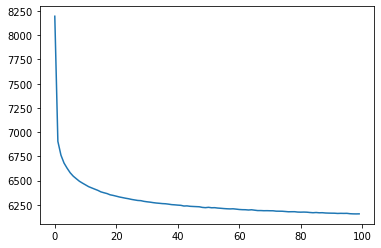

In [34]:
plt.plot(average_loss)

/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


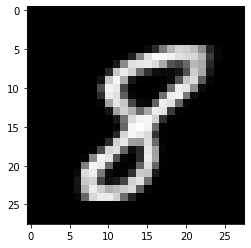

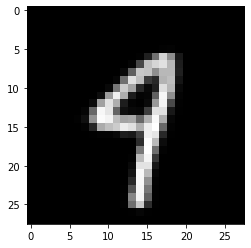

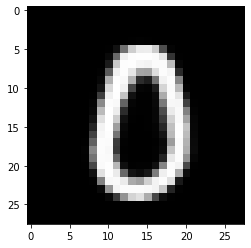

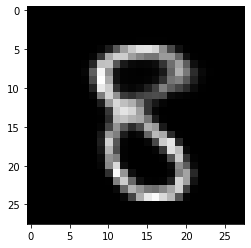

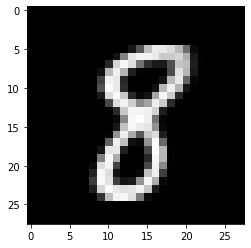

In [62]:

def format_batch(images):
    return torch.permute(images, (0, 2, 3, 1))*255.0 # damn this is cursed
    
# now lets see how things went
model.eval()
with torch.no_grad():
    for batch, _ in loader:
        images, _, _ = model(batch)        
        images = images.cpu().clamp(0, 1)
        images = format_batch(images).detach().numpy()
        for i in range(5):
            plt.imshow(images[i], cmap="gray")
            plt.show()
        break
    

In [ ]:
filepath = "../mnist"
index = 0
model.eval()
saved_data = []
with torch.no_grad():
    for batch, _ in loader:
        batch = batch.cpu()
        og_images = batch

        embedding, _ = model.encoder(batch)        
        embedding = embedding.cpu().detach().numpy()

        for image, embed in zip(og_images, embedding):
            filename = f"train-{index}.png"
            save_image(image, f"{filepath}/images/{filename}")
            saved_data.append({"index": index, 
                               "filename": filename, 
                               "features": embed.tolist()})
            index += 1

In [70]:
with open(f"{filepath}/clusters/vae_mnist_train.json", "w") as outfile:
    json.dump({"dataset": "mnist",
               "train_instances": saved_data,
               "model_name": "conv_vae"}, outfile)